## <center>  Chest X-rays Detection

In [1]:
import sklearn
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import os

2025-02-18 22:16:54.302972: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-18 22:16:54.467698: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-18 22:16:54.545350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739913414.638838   10251 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739913414.666539   10251 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-18 22:16:54.876852: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

### 1) Download kaggle files

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: /home/antoine/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


We get the folder structure with the code:
```
tree -L 3 path
```

Which gives the following structure:
```
Path
└── chest_xray
    ├── chest_xray
    │   ├── test
    │   ├── train
    │   └── val
    ├── __MACOSX
    │   └── chest_xray
    ├── test
    │   ├── NORMAL
    │   └── PNEUMONIA
    ├── train
    │   ├── NORMAL
    │   └── PNEUMONIA
    └── val
        ├── NORMAL
        └── PNEUMONIA
```
Files in the NORMAL and PNEUMONIA folders are all of ".jpg" extension.

### 2) Verify the data

Using the kaggle datasets, you can usually assume the dataset will be of quality, however it's still important to know your data and verify what it looks like.

Let's check that !

In [3]:
# Get the paths for the train, test and val folders
chest_xray_path = path + "/chest_xray"
test_path = chest_xray_path + "/test"
train_path = chest_xray_path + "/train"
val_path = chest_xray_path + "/val"

In [4]:
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib

# Get the Normal and Pneumonia path from a  parent folder
def normal_n_pneumonia_paths(parent_folder_path):
    return (parent_folder_path + "/NORMAL"), ( parent_folder_path + "/PNEUMONIA")

# Return random images paths from the folder given
def select_random_images_from_folder(path_folder, number_images):
    list_path_images_train_normal = glob.glob(str(path_folder + "/*.jpeg"))
    
    array_numbers_len_list = np.arange(0, len(list_path_images_train_normal))
    
    # Select number_images numbers from the list
    list_random_numbers = np.random.choice(array_numbers_len_list, number_images)
    
    return [list_path_images_train_normal[i] for i in list_random_numbers]

# Print images from their path
def print_images_from_path(array_dim1_images_path):
    num_images = len(array_dim1_images_path)

    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 5, 5))  # One row, multiple columns
    
    if num_images == 1:  # Handle single image case
        axes = [axes]
    
    for ax, image_path in zip(axes, array_dim1_images_path):
        img = matplotlib.image.imread(image_path)  # Read image correctly
        ax.imshow(img, cmap="gray")
        ax.axis("off")  # Hide axes
    
    plt.show()

# Select random images from the folder and isplay them
def select_n_display_images_from_folder(path_folder, number_images):
    list_random_images_paths = select_random_images_from_folder(path_folder, number_images)
    print_images_from_path(list_random_images_paths)
    return list_random_images_paths
    

/home/antoine/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/NORMAL


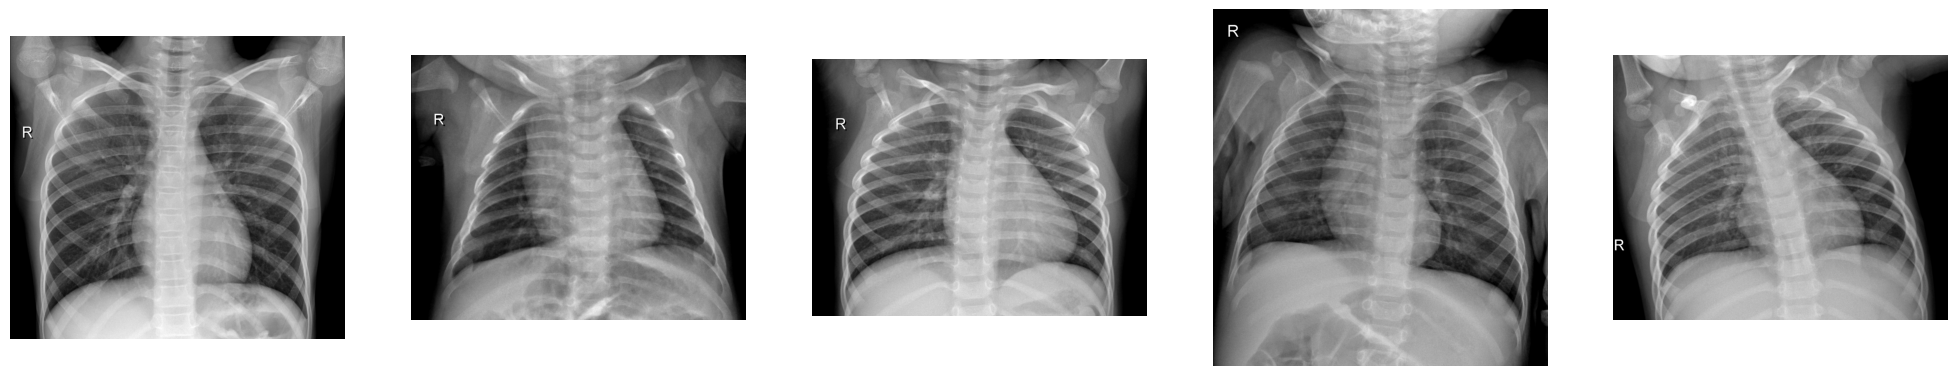

['/home/antoine/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/NORMAL/NORMAL2-IM-1334-0001.jpeg', '/home/antoine/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/NORMAL/IM-0481-0001.jpeg', '/home/antoine/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/NORMAL/NORMAL2-IM-0935-0001.jpeg', '/home/antoine/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/NORMAL/NORMAL2-IM-1333-0001.jpeg', '/home/antoine/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/NORMAL/NORMAL2-IM-0683-0001.jpeg']


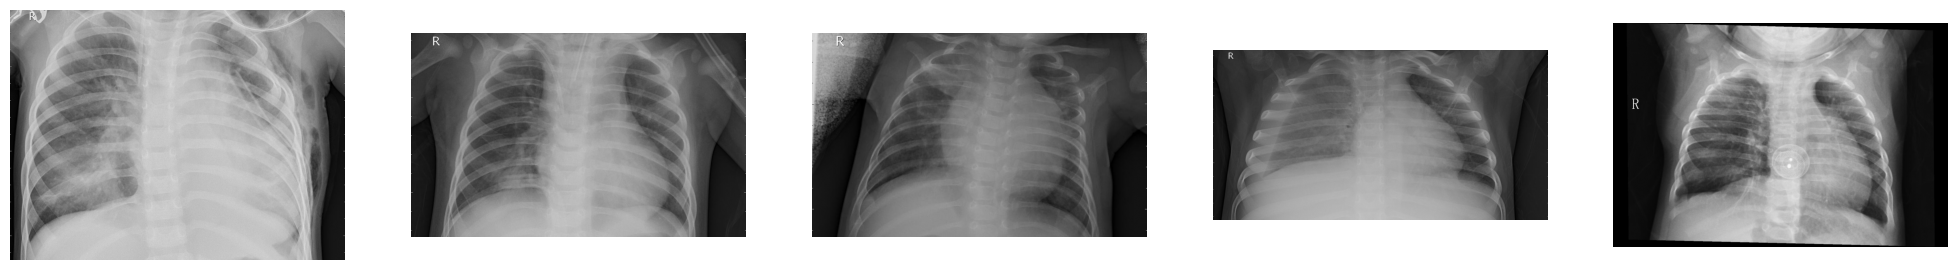

['/home/antoine/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/PNEUMONIA/person357_bacteria_1640.jpeg', '/home/antoine/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/PNEUMONIA/person597_bacteria_2450.jpeg', '/home/antoine/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/PNEUMONIA/person371_bacteria_1703.jpeg', '/home/antoine/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/PNEUMONIA/person1138_virus_1879.jpeg', '/home/antoine/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/PNEUMONIA/person1006_bacteria_2937.jpeg']


In [5]:
num_images_to_display = 5

train_normal_path, train_pneumonia_path = normal_n_pneumonia_paths(train_path)
print(train_normal_path)

list_random_images_paths_normal = select_n_display_images_from_folder(train_normal_path, num_images_to_display)
print(list_random_images_paths_normal)

list_random_images_paths_pneumonia = select_n_display_images_from_folder(train_pneumonia_path, num_images_to_display)
print(list_random_images_paths_pneumonia)


### 3) Standardise the data

The data needs to have the same shape, rescaling pixel value to [0,1]

#### Reshape

In [6]:
from PIL import Image
from collections import defaultdict

# Verify the shapes existing

def count_num_images_shapes(folder_path):
    # Dictionary to count occurrences of each unique shape
    shape_counts = defaultdict(int)

    # Loop through all files in the folder
    for filename in os.listdir(folder_path):
        if filename.lower().endswith((".jpg", ".jpeg")):
            file_path = os.path.join(folder_path, filename)
            with Image.open(file_path) as img:
                shape = img.size  # (width, height)
                shape_counts[shape] += 1  # Count occurrences of each shape

    # Print unique shapes and their counts
    for shape, count in shape_counts.items():
        print(f"Shape {shape}: {count} images")
    
    return shape_counts

In [7]:
dictionary_shapes = count_num_images_shapes(train_normal_path)

Shape (2018, 1881): 1 images
Shape (1880, 1552): 1 images
Shape (2172, 1615): 1 images
Shape (1400, 1239): 1 images
Shape (1676, 1400): 1 images
Shape (1874, 1774): 1 images
Shape (1458, 1248): 1 images
Shape (1978, 1777): 1 images
Shape (1480, 1228): 2 images
Shape (1558, 1279): 2 images
Shape (1920, 1920): 1 images
Shape (1846, 1488): 1 images
Shape (1666, 1333): 1 images
Shape (1955, 1672): 1 images
Shape (1692, 1878): 1 images
Shape (1608, 1364): 1 images
Shape (1828, 1781): 1 images
Shape (1728, 1518): 1 images
Shape (2226, 2013): 1 images
Shape (2031, 1693): 1 images
Shape (1256, 1097): 1 images
Shape (1720, 1449): 1 images
Shape (1716, 1202): 1 images
Shape (1920, 1801): 1 images
Shape (1844, 1256): 1 images
Shape (1666, 1290): 1 images
Shape (1686, 1231): 1 images
Shape (1786, 1449): 1 images
Shape (1368, 1078): 1 images
Shape (1296, 1200): 1 images
Shape (1770, 1325): 1 images
Shape (1470, 1248): 1 images
Shape (1156, 1237): 1 images
Shape (1944, 1708): 1 images
Shape (976, 80

All the shapes are different, let's try ro find a shape that would work on all images, starting with the minimum shape (both width and height).

In [8]:
list_shapes = list(dictionary_shapes.keys())

# Get the min width and heigth
min_width, min_height = list(map(min, zip(*list_shapes)))
print(f"Min width: {min_width} \nMin height: {min_height}")

Min width: 912 
Min height: 672


We like powers of 2 for shapes as it works very well with maximisation of physical space, pooling steps, etc.

Let's reshape our images to (512, 512) wich is the closest power of 2 to the shapes above, and obviously it's a lower value to avoid using padding on images.

In [9]:
def resize_images_in_folder(folder_path, target_size):
    # Dictionary to store resized image variables
    resized_images = {}

    # Loop through images and resize in-memory
    for filename in os.listdir(folder_path):
        if filename.lower().endswith((".jpg", ".jpeg")):
            file_path = os.path.join(folder_path, filename)
            
            # Open and resize the image
            img = Image.open(file_path)
            img_resized = img.resize(target_size)  # Resize in memory
            
            # Store in dictionary
            resized_images[filename] = img_resized

    return resized_images

In [10]:
target_size = (512, 512)  # Desired shape
dict_resized_images = resize_images_in_folder(train_normal_path, target_size)

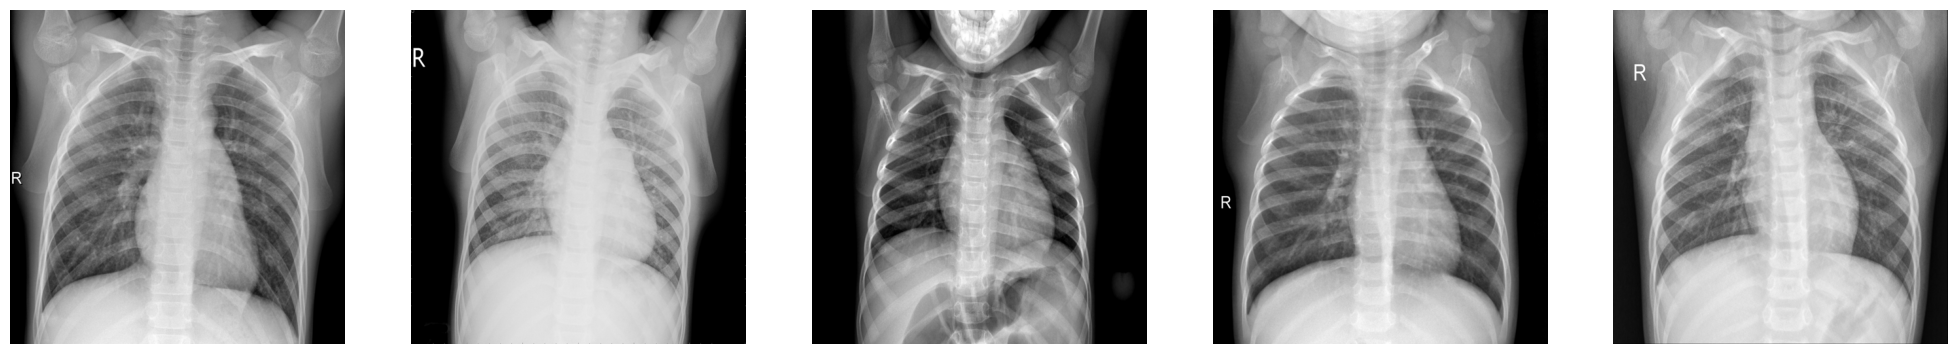

In [11]:
# Show resized images (for verification)

num_images = 5
fig, axes = plt.subplots(1, num_images, figsize=(num_images * 5, 5))  # One row, multiple columns

for ax, img in zip(axes, list(dict_resized_images.values())):
    ax.imshow(img, cmap="gray")
    ax.axis("off")  # Hide axes

All images seem to have been resized without any issues, let's start loading the whole dataset for training.

In [12]:
# Import the data

def get_dataset(dataset_folder_path):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        dataset_folder_path,
        image_size=target_size,
        batch_size=1,
        label_mode="categorical" # Use integers labels to categorise the images
    )
    return dataset

train_dataset = get_dataset(train_path)

validation_dataset = get_dataset(val_path)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


2025-02-18 22:17:25.862357: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


My computer has very very limited ressources, let's try to reduce the number of images.

In [13]:
import tensorflow as tf

# Configurations
nb_images = 10  # Number of images per subfolder
batch_size = 1

# Select N images per class
def filter_n_images(keras_dataset, N):
    class_counts = {}
    filtered_images, filtered_labels = [], []

    for image, label in keras_dataset:
        # Extract class index from one-hot encoded label
        label_int = tf.argmax(label, axis=-1).numpy().item()  # Convert to scalar
        
        if class_counts.get(label_int, 0) < N:
            # Convert image to grayscale
            grayscale_image = tf.image.rgb_to_grayscale(image[0])  # Remove batch dim & convert
            filtered_images.append(grayscale_image)
            filtered_labels.append(label_int)
            class_counts[label_int] = class_counts.get(label_int, 0) + 1
        
        if all(count >= N for count in class_counts.values()):
            break  # Stop when we have enough samples per class
        
    # Convert lists to tensors
    filtered_images = tf.stack(filtered_images)  # Stack images into a single tensor
    filtered_labels = tf.convert_to_tensor(filtered_labels, dtype=tf.int32)
    
    # Create a dataset without batching first
    dataset = tf.data.Dataset.from_tensor_slices((filtered_images, filtered_labels))
    
    # Shuffle the dataset to mix labels
    dataset = dataset.shuffle(buffer_size=len(filtered_images))  # Shuffle the entire dataset
    
    # Batch the dataset after shuffling
    batched_dataset = dataset.batch(batch_size)
    
    return batched_dataset

# Assuming train_dataset is already defined
train_dataset = filter_n_images(train_dataset, nb_images)

# Check dataset
for images, labels in train_dataset.take(1):
    print("Images shape:", images.shape)  # Should be (batch_size, 512, 512, 1)
    print("Labels shape:", labels.shape)  # Should be (batch_size,)
    print("Unique labels in batch:", tf.unique(labels).y.numpy())  # Check unique labels in the batch

Images shape: (1, 512, 512, 1)
Labels shape: (1,)
Unique labels in batch: [1]


2025-02-18 22:17:26.198897: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [14]:
label_counts = {0: 0, 1: 0}
for images, labels in train_dataset:
    for label in labels.numpy():
        label_counts[label] += 1
print("Label counts:", label_counts)

Label counts: {0: 10, 1: 10}


2025-02-18 22:17:26.222059: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### 4) Creation of model

In [15]:
import keras
from keras import layers

def basic_CNN_model(input_shape, nb_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x) # Picture of shape (256,256) after
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.25)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x) # It's 256 because the shape of the image at that stage is (256,256)
    outputs = layers.Dense(nb_classes , activation="sigmoid")(x) # We nb_classes is 2 because we have 2 classes: Normal and Pneumonia
    return keras.Model(inputs, outputs)

### 5) Training

In [16]:
input_shape = (512, 512, 1)  # Desired shape
nb_classes = 2
epochs = 10

model = basic_CNN_model(input_shape,nb_classes)

model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss='binary_crossentropy',
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]

history = model.fit(
    train_dataset,
    epochs=epochs,
    callbacks=callbacks,
    batch_size=batch_size,
    validation_data=validation_dataset,
    verbose=1
)


2025-02-18 22:17:26.273807: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 8589934592 exceeds 10% of free system memory.
2025-02-18 22:17:28.074593: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 8589934592 exceeds 10% of free system memory.


: 

In [ ]:
# Access history data
print(history.history.keys())  # Shows available metrics like loss, accuracy, etc.
print(history.history['loss'])  # Prints loss values per epoch
print(history.history['acc'])  # Prints accuracy values per epoch

In [ ]:
# Plot training loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()